In [119]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import sklearn.metrics as metrics
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [120]:
BATCH_SIZE = 128

## transformations
transform = transforms.Compose([transforms.ToTensor()])

## download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,shuffle=True, num_workers=2)

## download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

469


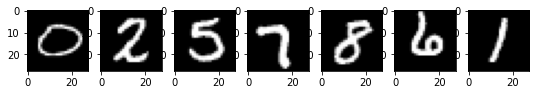

In [121]:
# Show some MNIST examples
print(len(trainloader))
num = 7
fig, axes = plt.subplots(1, num, figsize=(9, 9))
for idx in range(num):
    r = np.random.randint(0, len(trainset)-1)
    x = trainset[r][0]
    image = x.detach().numpy()[0]
    # image = image[0]
    axes[idx].imshow(image, cmap="gray")
plt.show()

In [123]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        # 28x28x1 => 26x26x32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.d1 = nn.Linear(26 * 26 * 32, 12)
        self.d2 = nn.Linear(12, 10)

    def forward(self, x):
        # 32x1x28x28 => 32x32x26x26
        x = self.conv1(x)
        x = F.relu(x)

        # flatten => 32 x (32*26*26)
        x = x.flatten(start_dim = 1)
        #x = x.view(32, -1)

        # 32 x (32*26*26) => 32x128
        x = self.d1(x)
        x = F.relu(x)

        # logits => 32x10
        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        return out

In [124]:
learning_rate = 0.001
num_epochs = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    ## training step
    for i, (images, labels) in enumerate(trainloader):               
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += (torch.argmax(logits, 1).flatten() == labels).type(torch.float).mean().item()
    
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' %(epoch, train_running_loss / i, train_acc/i))

Epoch: 0 | Loss: 1.8906 | Train Accuracy: 0.58
Epoch: 1 | Loss: 1.7202 | Train Accuracy: 0.75
Epoch: 2 | Loss: 1.6946 | Train Accuracy: 0.77
Epoch: 3 | Loss: 1.6833 | Train Accuracy: 0.78
Epoch: 4 | Loss: 1.6347 | Train Accuracy: 0.83


In [126]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += (torch.argmax(outputs, 1).flatten() == labels).type(torch.float).mean().item()
    preds = torch.argmax(outputs, 1).flatten().cpu().numpy()
        
print('Test Accuracy: %.2f'%(test_acc/i))

Test Accuracy: 0.97


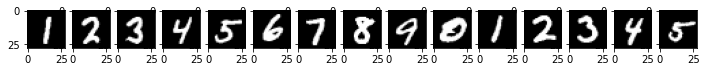

[1 2 3 4 5 6 7 8 9 0 1 2 3 4 5]


In [269]:
fig, axes = plt.subplots(1, 15, figsize=(12, 12))
for idx in range(15):
    x = images[idx]
    image = x.detach().numpy()[0]
    axes[idx].imshow(image, cmap="gray",)
plt.show()
print(preds[:15])


In [118]:
for idx in range(15):
    rand = np.random.randint(0, len(testset) - 1)    
    img = testset[rand][0]
    imgR = img.reshape([1, 1, 28, 28])
    out = model(imgR)
    pred = torch.argmax(out, 1).flatten().cpu().numpy()
    realNum = testset[rand][1]
    predNum = pred[0]
    print(f"Real={realNum}, Prediction={predNum}, {realNum == predNum} \t{rand}")

Real=2, Prediction=2, True 	9603
Real=2, Prediction=2, True 	5099
Real=1, Prediction=1, True 	7262
Real=3, Prediction=3, True 	4785
Real=8, Prediction=3, False 	3206
Real=3, Prediction=3, True 	3045
Real=6, Prediction=6, True 	1536
Real=3, Prediction=3, True 	1098
Real=3, Prediction=3, True 	8660
Real=9, Prediction=9, True 	862
Real=0, Prediction=0, True 	1416
Real=8, Prediction=8, True 	5680
Real=5, Prediction=8, False 	5174
Real=4, Prediction=4, True 	6332
Real=8, Prediction=8, True 	3502


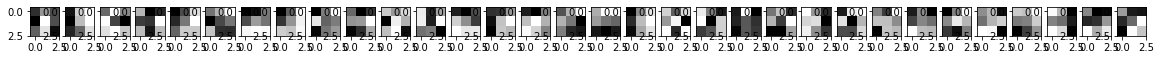

In [164]:
fig, axes = plt.subplots(1, 32, figsize=(20, 20))
for idx in range(32):
    blah = model.conv1.weight[idx][0]

    axes[idx].imshow(blah.detach().numpy(), cmap="gray")

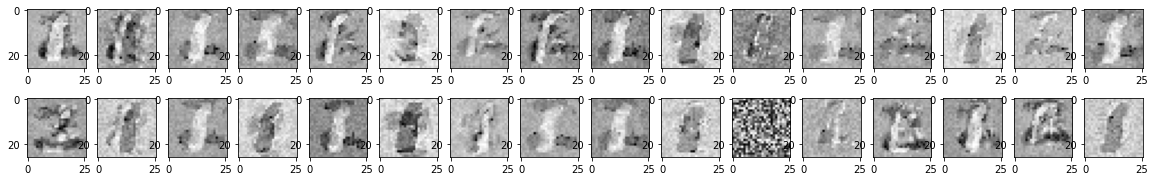

In [280]:
# D1 weights
d1Idx = 2

fig, axes = plt.subplots(2, 16, figsize=(20, 3))

blah = model.d1.weight[d1Idx].detach().numpy()
blah2 = blah.reshape(32, 26, 26)

for i in range(2):
    for i2 in range(len(axes[1])):
        idx = (i * 16) + i2
        axes[i][i2].imshow(blah2[idx], cmap="binary")
      